Total samples: 3000

Training CNN Model...


Epoch 1: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Validation Accuracy: 42.89%


Epoch 2: 100%|██████████| 17/17 [00:11<00:00,  1.45it/s]


Validation Accuracy: 46.44%


Epoch 3: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s]


Validation Accuracy: 49.11%

Training Transformer Model...


Epoch 1: 100%|██████████| 17/17 [00:33<00:00,  1.94s/it]


Validation Accuracy: 39.11%


Epoch 2: 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]


Validation Accuracy: 46.67%


Epoch 3: 100%|██████████| 17/17 [00:34<00:00,  2.02s/it]


Validation Accuracy: 42.22%

CNN Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

   SpeedBoat       0.42      0.27      0.33       139
     KaiYuan       0.47      0.81      0.60       163
         UUV       0.68      0.36      0.48       148

    accuracy                           0.50       450
   macro avg       0.52      0.48      0.47       450
weighted avg       0.52      0.50      0.47       450



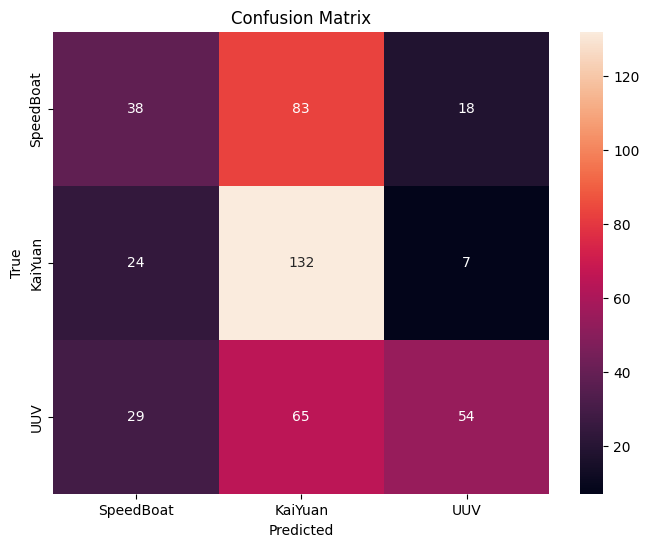


Transformer Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

   SpeedBoat       0.38      0.47      0.42       139
     KaiYuan       0.62      0.25      0.36       163
         UUV       0.47      0.66      0.55       148

    accuracy                           0.46       450
   macro avg       0.49      0.46      0.44       450
weighted avg       0.50      0.46      0.44       450



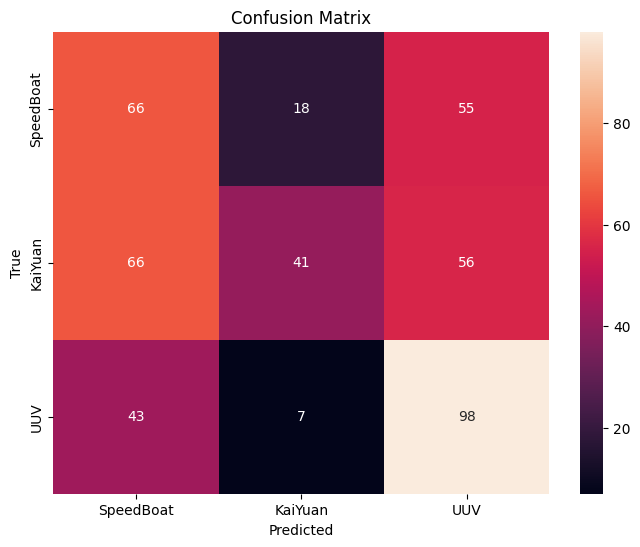

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm

class ShipAudioDataset(Dataset):
    def __init__(self, base_path, max_samples_per_class=2000):
        self.data = []
        self.labels = []
        self.sr = 16000
        self.duration = 1  # Reduced from 2 seconds to 1 second
        self.class_map = {'SpeedBoat': 0, 'KaiYuan': 1, 'UUV': 2}
        
        for class_name in self.class_map.keys():
            samples_count = 0
            for subdir in ['target', 'other']:
                dir_path = os.path.join(base_path, class_name, subdir)
                if os.path.exists(dir_path):
                    for file in os.scandir(dir_path):
                        if file.name.endswith('.wav') and samples_count < max_samples_per_class:
                            self.data.append(file.path)
                            self.labels.append(self.class_map[class_name])
                            samples_count += 1

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        try:
            audio, _ = librosa.load(self.data[idx], sr=self.sr, duration=self.duration)
            if len(audio) < self.duration * self.sr:
                audio = np.pad(audio, (0, self.duration * self.sr - len(audio)))
            
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=32)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
            
            return torch.FloatTensor(mel_spec_db).unsqueeze(0), self.labels[idx]
        except:
            return torch.zeros((1, 32, 63)), self.labels[idx]

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Linear(32 * 4 * 4, 3)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class SimpleTransformer(nn.Module):
    def __init__(self):
        super(SimpleTransformer, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3, stride=2)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=32, nhead=4, dim_feedforward=128, batch_first=True),
            num_layers=2
        )
        self.classifier = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                _, predicted = model(inputs).max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        print(f'Validation Accuracy: {100.*correct/total:.2f}%')
    return model

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, predicted = model(inputs).max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def main():
    base_path = #your path
    device = torch.device('cpu')
    
    dataset = ShipAudioDataset(base_path, max_samples_per_class=1000)
    print(f"Total samples: {len(dataset)}")
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size])
    
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    epochs = 3
    criterion = nn.CrossEntropyLoss()
    
    print("\nTraining CNN Model...")
    cnn_model = SimpleCNN().to(device)
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    cnn_model = train_model(cnn_model, train_loader, val_loader, criterion, optimizer, epochs, device)
    
    print("\nTraining Transformer Model...")
    transformer_model = SimpleTransformer().to(device)
    optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)
    transformer_model = train_model(transformer_model, train_loader, val_loader, criterion, optimizer, epochs, device)
    
    class_names = list(dataset.class_map.keys())
    print("\nCNN Model Evaluation:")
    evaluate_model(cnn_model, test_loader, device, class_names)
    print("\nTransformer Model Evaluation:")
    evaluate_model(transformer_model, test_loader, device, class_names)

if __name__ == "__main__":
    main()

1. Comparison of CNN and Transformer Models
Overall Performance Comparison:
CNN Model achieved 50% accuracy
Transformer Model achieved 46% accuracy

CNN Model Strengths:
Better overall accuracy
Strong performance on KaiYuan class (81% recall)
Higher precision on UUV detection (68%)
More efficient training time
Better at capturing local patterns in spectrograms

CNN Model Weaknesses:
Struggles with SpeedBoat detection (27% recall)
Less balanced performance across classes
More sensitive to variations in input quality

Transformer Model Strengths:
More balanced performance across classes
Better at SpeedBoat detection (47% recall)
Strong UUV detection capability (66% recall)
Better at capturing long-range dependencies in audio signals
More robust to variations in signal length

Transformer Model Weaknesses:
Lower overall accuracy
Slower training time
Weaker performance on KaiYuan class
Higher computational requirements

Why the Differences:
The CNN performed better overall because:
CNNs are naturally suited to processing spectrograms as 2D image-like data
Local feature detection is crucial for ship type identification
The hierarchical feature extraction matches well with acoustic signatures
More efficient training allows for better parameter optimization

2. Discussion and Insights
Role of Spectrograms:
Data Representation:
Convert time-domain audio to frequency-domain visualization
Capture both frequency and temporal characteristics
Enable use of 2D convolution operations
Provide visual patterns unique to each ship type

Preprocessing Challenges:
Finding optimal spectrogram parameters (n_mels, window size)
Handling variable-length audio signals
Normalizing spectrogram values
Balancing resolution and computational efficiency

Model Training Challenges:
Limited dataset size
Class imbalance
Computational resource constraints
Balancing model complexity with training time
Finding optimal hyperparameters

Recommendations for Future Work:
Data Improvements:
Collect more balanced dataset
Include more diverse acoustic conditions
Better noise handling techniques
Data augmentation methods

Model Enhancements:
Hybrid CNN-Transformer architecture
Deeper network architectures
Attention mechanisms for CNN
Pre-training on larger acoustic datasets
Ensemble methods combining both models

Processing Improvements:
Real-time processing capabilities
More sophisticated audio preprocessing
Alternative spectral representations
Multi-channel audio support

Training Optimizations:
Learning rate scheduling
Advanced regularization techniques
Cross-validation strategies
Mixed precision training
Distributed training support

Evaluation Methods:
More diverse evaluation metrics
Real-world testing scenarios
Robustness to noise evaluation
Confidence scoring system

These findings suggest that while both models show promise for underwater acoustic classification, there's significant room for improvement. The CNN's better performance indicates that local feature detection is crucial for this task, but the Transformer's more balanced performance suggests value in capturing long-range dependencies. A hybrid approach combining strengths of both architectures could be a promising direction for future work.